# Fit Cole-Cole conductivity with Stretched Exponential

**Author**: [Seogi Kang](https://github.com/sgkang)

This notebooks shows how we fitted Cole-Cole conductivity by using Stretched Exponential (SE) function. This notebooks was used to produce Figure 1 in Kang et al. (2019). 

In [14]:
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.StretchedExponential import SEInvImpulseProblem, SESurvey
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
from simpegEM1D import DigFilter
%matplotlib inline

In [1]:
import matplotlib 
matplotlib.rcParams["font.size"] = 14
figdir = "./figures/"

## Create Cole-Cole function in frequency-domain

In [15]:
def ColeColeSeigel(f, sigmaInf, eta, tau, c):
    w = 2*np.pi*f
    return sigmaInf*(1 - eta/(1 + (1j*w*tau)**c))

## Use SimPEG's inversion module to fit Cole-Cole with SE

In [16]:
def estimate_se_from_colecole(eta0, tau0, c0, siginf=1.):
    time = np.logspace(-6,np.log10(0.01), 41)
    wt, tbase, omega_int = DigFilter.setFrequency(time)
    frequency = omega_int / (2*np.pi)
    sigma = ColeColeSeigel(frequency, siginf, eta0, tau0, c0)
    sigTCole = DigFilter.transFiltImpulse(sigma, wt, tbase, omega_int, time, tol=1e-12)
    wires = Maps.Wires(('eta', 1), ('tau', 1), ('c', 1))
    taumap = Maps.ExpMap(nP=1)*wires.tau
    survey = SESurvey()
    dtrue = -sigTCole
    survey.dobs = dtrue
    m1D = Mesh.TensorMesh([np.ones(3)])
    prob = SEInvImpulseProblem(m1D, etaMap = wires.eta, tauMap = taumap, cMap=wires.c)
    prob.time = time
    prob.pair(survey)
    m0 = np.r_[eta0, np.log(tau0), c0]
    perc = 0.01
    dmisfitpeta = DataMisfit.l2_DataMisfit(survey)
    dmisfitpeta.W = 1/(abs(survey.dobs)*perc)
    reg = Regularization.Simple(m1D)
    opt = Optimization.ProjectedGNCG(maxIter = 10)
    invProb = InvProblem.BaseInvProblem(dmisfitpeta, reg, opt)
    # Create an inversion object
    target = Directives.TargetMisfit()
    betaSch = Directives.BetaSchedule(coolingFactor=1, coolingRate=1)
    # invProb.beta = 0.
    inv = Inversion.BaseInversion(invProb, directiveList=[betaSch, target])
    reg.mref = 0.*m0
    prob.counter = opt.counter = Utils.Counter()
    opt.LSshorten = 0.5
    opt.remember('xc')
    opt.tolX = 1e-20
    opt.tolF = 1e-20
    opt.tolG = 1e-20
    opt.eps = 1e-20
    # opt.lower = 0.
    mopt = inv.run(m0)
    return mopt, invProb.dpred, survey.dobs

In [17]:
eta1, tau1, c1 = 0.1, 1e-3, 0.7
mopt1, pred1, dobs1 = estimate_se_from_colecole(eta1, tau1, c1)
eta1_se, tau1_se, c1_se = mopt1[0], np.exp(mopt1[1]), mopt1[2]

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  5.85e+03  7.76e+01  5.93e+03    1.30e+05      0              
   1  1.00e+00  2.09e+03  7.59e+01  2.17e+03    9.39e+03      0              
   2  1.00e+00  1.98e+03  7.51e+01  2.05e+03    1.38e+03      0              
   3  1.00e+00  1.98e+03  7.50e+01  2.05e+03    7.46e+01      0   Skip BFGS  
   4  1.00e+00  1.98e+03  7.50e+01  2.05e+03    1.61e+01      0   Skip BFGS  
   5  1.00e+00  1.98e+03  7.50e+01  2.05e+03    1.51e+00      0  

In [18]:
eta2, tau2, c2 = 0.1, 1e-2, 0.7
mopt2, pred2, dobs2 = estimate_se_from_colecole(eta2, tau2, c1)
eta2_se, tau2_se, c2_se = mopt2[0], np.exp(mopt2[1]), mopt2[2]

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  1.69e+03  3.60e+01  1.72e+03    1.48e+05      0              
   1  1.00e+00  1.60e+02  4.14e+01  2.01e+02    1.31e+05      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.7257e-17
0 : |xc-x_last| = 4.8598e-03 <= tolX*(1+|x0|) = 5.6591e-20
0 : |proj(x-g)-x|    = 1.3148e+05 <= tolG          = 1.0000e-20
0 : |proj(x-g)-x|    = 1.3148e+05 <= 1e3*eps       = 1.0000e-

In [19]:
eta1, tau1, c1 = 0.1, 1e-3, 0.3
mopt1, pred1, dobs1 = estimate_se_from_colecole(eta1, tau1, c1)
eta1_se, tau1_se, c1_se = mopt1[0], np.exp(mopt1[1]), mopt1[2]

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  1.62e+04  7.44e+01  1.63e+04    1.35e+06      0              
   1  1.00e+00  1.88e+02  7.71e+01  2.65e+02    1.83e+04      0              
   2  1.00e+00  6.51e+01  7.94e+01  1.45e+02    4.76e+03      0   Skip BFGS  
   3  1.00e+00  6.46e+01  7.96e+01  1.44e+02    1.71e+01      0   Skip BFGS  
   4  1.00e+00  6.45e+01  7.96e+01  1.44e+02    9.36e-02      0   Skip BFGS  
   5  1.00e+00  6.45e+01  7.96e+01  1.44e+02    9.36e-02      0  

In [20]:
eta2, tau2, c2 = 0.1, 1e-3, 0.5
mopt2, pred2, dobs2 = estimate_se_from_colecole(eta2, tau2, c2)
eta2_se, tau2_se, c2_se = mopt2[0], np.exp(mopt2[1]), mopt2[2]

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  7.07e+03  7.60e+01  7.14e+03    5.30e+05      0              
   1  1.00e+00  6.18e+02  7.64e+01  6.94e+02    2.80e+04      0              
   2  1.00e+00  6.07e+02  7.64e+01  6.84e+02    2.01e+02      0              
   3  1.00e+00  6.07e+02  7.64e+01  6.84e+02    1.02e+01      0              
   4  1.00e+00  6.07e+02  7.64e+01  6.84e+02    5.08e-01      0              
   5  1.00e+00  6.07e+02  7.64e+01  6.84e+02    2.59e-02      0  

In [21]:
eta3, tau3, c3 = 0.1, 1e-3, 0.7
mopt3, pred3, dobs3 = estimate_se_from_colecole(eta3, tau3, c3)
eta3_se, tau3_se, c3_se = mopt3[0], np.exp(mopt3[1]), mopt3[2]

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  5.85e+03  7.76e+01  5.93e+03    1.30e+05      0              
   1  1.00e+00  2.09e+03  7.59e+01  2.17e+03    9.39e+03      0              
   2  1.00e+00  1.98e+03  7.51e+01  2.05e+03    1.38e+03      0              
   3  1.00e+00  1.98e+03  7.50e+01  2.05e+03    7.46e+01      0   Skip BFGS  
   4  1.00e+00  1.98e+03  7.50e+01  2.05e+03    1.61e+01      0   Skip BFGS  
   5  1.00e+00  1.98e+03  7.50e+01  2.05e+03    1.51e+00      0  

In [22]:
time = np.logspace(-6,np.log10(0.01), 41)

In [23]:
import matplotlib
matplotlib.rcParams['font.size'] = 14

In [24]:
print (("True      eta, tau and c = %.e, %.e and %3.1f")%(eta1, tau1, c1))
print (("Estimated eta, tau and c = %.e, %.e and %3.1f")%(eta1_se, tau1_se, c1_se))

True      eta, tau and c = 1e-01, 1e-03 and 0.3
Estimated eta, tau and c = 9e-02, 8e-04 and 0.2


In [25]:
print (("True      eta, tau and c = %.e, %.e and %3.1f")%(eta2, tau2, c2))
print (("Estimated eta, tau and c = %.e, %.e and %3.1f")%(eta2_se, tau2_se, c2_se))

True      eta, tau and c = 1e-01, 1e-03 and 0.5
Estimated eta, tau and c = 9e-02, 1e-03 and 0.4


In [26]:
print (("True      eta, tau and c = %.e, %.e and %3.1f")%(eta3, tau3, c3))
print (("Estimated eta, tau and c = %.e, %.e and %3.1f")%(eta3_se, tau3_se, c3_se))

True      eta, tau and c = 1e-01, 1e-03 and 0.7
Estimated eta, tau and c = 9e-02, 1e-03 and 0.6


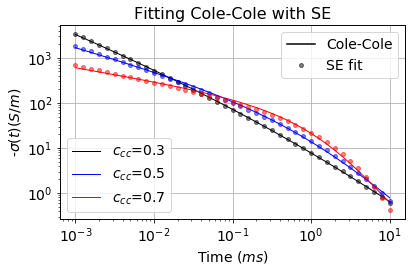

In [28]:
# later make a table here.
fig = plt.figure()
ax = plt.subplot(111)
ax.loglog(time*1e3, dobs1, 'k', lw=1)
ax.loglog(time*1e3, dobs2, 'b', lw=1)
ax.loglog(time*1e3, dobs3, 'r', lw=1)
ax.legend(("$c_{cc}$=0.3", "$c_{cc}$=0.5", "$c_{cc}$=0.7",), loc=3)
ax.loglog(time*1e3, pred1, 'ko', alpha = 0.5, ms=4)
ax.loglog(time*1e3, pred2, 'bo', alpha = 0.5, ms=4)
ax.loglog(time*1e3, pred3, 'ro', alpha = 0.5, ms=4)
ax.set_xlabel("Time ($ms$)")
ax.set_ylabel("-$\sigma(t) (S/m)$")
ax_1 = ax.twinx()
ax_1.set_yticks([])
ax_1.plot(0., 0., 'k')
ax_1.plot(0., 0., 'ko', alpha = 0.5, ms=4)
ax_1.legend(("Cole-Cole", "SE fit"))
# plt.legend((l1, l2), ("Cole-Cole"))
# plt.legend(("Cole-Cole", "Stretched Exp."), fontsize = 12)
ax.grid(True)
ax.set_title("Fitting Cole-Cole with SE", fontsize = 16)
plt.tight_layout()
fig.savefig(figdir+"se_curves", dpi=200)